# Basic Text Classification

**Aim**: Classify IMDB comments as positive or negative (i.e. sentiment)

We'll train a binary classifier to perform sentiment analysis on an IMDB dataset.

Hence binary, either positive or negative.

**Dataset**: 50,000 movie reviews. 25,000 reviews for training and 25,000 reviews for testing 

The data is *balanced* as it has equal number training and testing. 


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Download the data - (run once! jupyter cell converted to raw)

general cleanup: move the folder to data - (run once! jupyter cell converted to raw)

Create a path to the data 

In [2]:
dataset_dir = os.path.join("./data/", 'aclImdb')

In [3]:
print(dataset_dir)

os.listdir(dataset_dir)

./data/aclImdb


['.DS_Store', 'imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 '.DS_Store',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

`pos` and `neg` directories contain many reviews in text files

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the data

1. Reformat the directory structure (`text_dataset_from_directory` will be used)
2. Create a labeled `tf.data.Dataset`


`tf.data` is:
* iterable 
* can pass directly into `model.fit`



N.B. `text_dataset_from_directory` needs the following data sctructure:

eg. 

`class_a` will be `neg`  

`class_b` will be `pos` 

### 1. Reformat the directory structure

In [6]:
os.listdir(train_dir)

['urls_unsup.txt',
 '.DS_Store',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

### 2. Create a labeled `tf.data.Dataset`

"When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test."

The currect dataset lacks a validation dataset, we should create one.

Splitting 80:20 training:validation

We set a *seed* so as the data is split without overlapping

*batch size* is the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
   
batch size defalut = 32


In [7]:
seed=42

# training
print("training")

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/aclImdb/train',
    validation_split=0.2,
    subset='training',
    seed=seed
)

# validation
print("\nvalidating")

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/aclImdb/train',
    validation_split=0.2,
    subset='validation',
    seed=seed
)

# testing
print("\ntesting")

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('data/aclImdb/test')


training
Found 25000 files belonging to 2 classes.
Using 20000 files for training.

validating
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

testing
Found 25000 files belonging to 2 classes.


### Investigate the data

Note how the reviews contain html

In [8]:
print("label 0: ", raw_train_ds.class_names[0])
print("label 1: ", raw_train_ds.class_names[1])

label 0:  neg
label 1:  pos


In [9]:
for text, label in raw_train_ds.take(1):
    for i in range(3):
        print("review: ", text.numpy()[i])
        print("label: ", label.numpy()[i])
        print("\n")

review:  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label:  0


review:  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they g

### Prepare the data
* remove html
* remove punctuation
* vectorize text

*Tokenization* - split string into tokens, eg. sentance to words 

*Vectorization* - converting tokens to numbers, allows them to be fed into the neural network

We will use `preprocessing.TextVectorization`, this will remove punctuation but not html


In [10]:
# convert to lowercase and remove html

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


create the *vecorization* layer (standardize, tokenize, and vectorize)

it will use the `custom_standardization` and will output an `int` (vectorization)

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length=sequence_length
)

next we fit the state of the preprocessing layer to the dataset, using `adapt` 

In [12]:
# first remove the labels (i.e. text only dataset)
train_text = raw_train_ds.map(lambda x, y : x)

# then call adapt
vectorize_layer.adapt(train_text)


defien a vectorization function

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

**investigate the data**

In [15]:
print('1287: ', vectorize_layer.get_vocabulary()[1287])
print('length: ', len(vectorize_layer.get_vocabulary()))

1287:  silent
length:  10000


In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

### Map the vectorization layer to the datasets


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

2 methods used when loading data, to make sure the I/O does not becoming blocking

`cache()` - cache the data in memory, we can also store on disk if very large

`prefetch()` - overlaps preprocessing and model execution when training

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

Layers:
1. `Embedding` - takes ints and looks up embedding vector for each word-index. Vectors are learned during training
2. `GlobalAveragePooling1D` - "returns a fixed-length output vector for each example by averaging over the sequence dimension"
3. `Dense` - hidden, fully connected layer with $n$ hidden units
4. Single output node, densly connected



`Dropout` helps prevent overfitting

N.B. embedding is the process of taking high-dimensional vectors and passing them into a (simpler) low-dimensional space.

In [23]:
embedding_dim = 16

model= tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Loss function and optimiser

Binary and model outputs probability, we will use `losses.BinaryCrossentropy`.



In [24]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

## Train the model

In [25]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 13s 20ms/step - loss: 0.6809 - binary_accuracy: 0.6177 - val_loss: 0.6127 - val_binary_accuracy: 0.7746
Epoch 2/10
625/625 [==============================] - 2s 2ms/step - loss: 0.5781 - binary_accuracy: 0.7856 - val_loss: 0.4971 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 2s 2ms/step - loss: 0.4648 - binary_accuracy: 0.8370 - val_loss: 0.4193 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3901 - binary_accuracy: 0.8619 - val_loss: 0.3733 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 2s 2ms/step - loss: 0.3426 - binary_accuracy: 0.8756 - val_loss: 0.3445 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3101 - binary_accuracy: 0.8885 - val_loss: 0.3255 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 2s 2ms/s

## Evaluate the model

In [26]:
model.evaluate(test_ds)

782/782 [==============================] - 16s 20ms/step - loss: 0.3100 - binary_accuracy: 0.8737


[0.31000372767448425, 0.8737199902534485]

our accuracy is about 87% with this approach (a quick and dirty fix)

## Accuracy and loss over time
How well did the training go? 

We can plot *accuracy* and *loss* for the training and the validation.

`model.fit()` returns `history`, a dict of the training.history



**Training loss** is the error on the training set of data. 

**Validation loss** is the error after running the validation set of data through the trained network


In [28]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

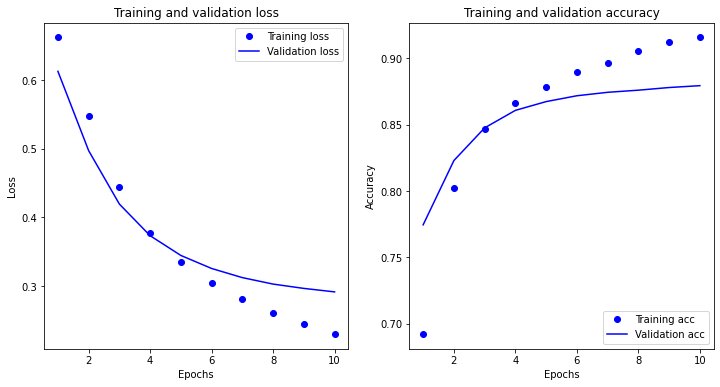

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


def plotVal():
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

def plotAcc():
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plotVal()
plt.subplot(1,2,2)
plotAcc()
plt.show()


**training**: loss decrease, and accuracy increase - what we want and expect

**validation**: loss and accuracy plateau before the training - not really what we want

From this the validation dataset (i.e. "new data") underperforms, due to *overfitting*. The model performs far better on the training dataset than it does on the new data.

## Export the model

We may want to include the `TextVectorization` layer in our model before feeding it more data. 

We can create a new model by using the existing trained one. 

In [32]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer = 'adam',
    metrics= ['accuracy']
)

In [44]:
# test with raw strings

examples = [
    "What a great film!",
    "load of crap",
    "best film of the year :)",
    "rubbish film, not worth your time"
]

export_model.predict(examples)


array([[0.6968127 ],
       [0.43794838],
       [0.6660558 ],
       [0.47758237]], dtype=float32)

In [45]:
print("label 0: ", raw_train_ds.class_names[0])
print("label 1: ", raw_train_ds.class_names[1])

label 0:  neg
label 1:  pos
